In [1]:
%matplotlib inline
from IPython.html.widgets import FloatProgress
from IPython.display import display

C:\Program Files\Anaconda2\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import gensim
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, precision_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

from create_dictionary import train_corpus, transform_doc2bow, tokenize
from sklearn.metrics.pairwise import cosine_similarity

from online_lsi_sim import sim_two_lsi, sim_all_lsi
from online_lda_sim import sim_two_lda, sim_all_lda
from word2vec_sim import sim_two_w2v, sim_all_w2v
from doc_sim import sim_two, sim_all

from create_model import *


C:\Program Files\Anaconda2\lib\site-packages\gensim-0.13.3-py2.7-win-amd64.egg\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Program Files\Anaconda2\lib\site-packages\gensim-0.13.3-py2.7-win-amd64.egg\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\gr

In [5]:
def collapse_spaces(x1):
    import re 
    x = re.sub(r'[^\x00-\x7F]+','', x1)
    x = re.sub(r'\s+', ' ', x)
    return x.strip()


In [7]:

dictionary = gensim.corpora.Dictionary.load("../data/reddit.gz")
fname = "../Reddit/reddit_dup_list.csv"

so_dat = pd.read_csv(fname)
so_dat_main = so_dat[['id', 'title', 'body', 'tag']]

# build each feature, and model
corpus = train_corpus(so_dat_main['body'].tolist(), dictionary)

# all these models have online learning support
print "training lda..."
lda_mod = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=7, minimum_probability=0.0)
print "training lsi..."
lsi_mod = gensim.models.lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=100)
print "training word2vec..."
w2v_mod = gensim.models.Word2Vec(min_count=5, sg=5)
sentences = [tokenize(collapse_spaces(str(x))) for x in so_dat_main['body'].tolist()]
w2v_mod.build_vocab(sentences )
w2v_mod.train(sentences)

training lda...
training lsi...
training word2vec...


2071

In [8]:
# read faq data in
label_dat = pd.read_csv("../Reddit/omscs-compiled-faq.csv")

In [56]:
dup_index = so_dat[~pd.isnull(so_dat.did)][["id", "did"]]
dup_pivot = pd.concat([pd.Series(row['id'], row['did'].split(" ")) for _, row in dup_index.iterrows()]).reset_index()
dup_pivot.columns = ["did", "id"]
dup_pivot.head()

,did,id
0,6,1479431351
1,1,1479428892
2,50,1479428892
3,1,1479410946
4,50,1479410946


In [54]:
label_dat.rename(columns={"Id":"did"}, inplace=True)
label_dat

,did,Question,Answer,Source
0,1,How difficult is course X? How many hours shou...,There is a fantastic unofficial course review ...,reddit
1,2,What should I take as a first course? What sho...,There are a lot of good threads on this. In ad...,reddit
2,3,Foundational courses? What are those? Is cours...,Take a look at the course list on the OMSCS we...,reddit
3,4,"What is this ""foundational course requirement""?",All new students must pass TWO foundational co...,reddit
4,5,I have my course plan all figured out! I have ...,"Good job preparing! However, not all courses a...",reddit
5,6,How many courses may I take?,You may only take 2 courses/semester until you...,reddit
6,7,Not all are offered in the summer? Which ones ...,There's no guarantee about a summer schedule b...,reddit
7,8,Where can I see the syllabus/reading/pre-reqs ...,\r\nThere are a couple places for this.\r\n\r\...,reddit
8,9,When are courses offered? How long are they?,"Courses are offered in the Fall, Spring, and S...",reddit
9,10,How many courses are required to graduate?,30 hours must be completed to graduate. 15-18 ...,reddit


In [64]:
dup_pivot["did"] = dup_pivot["did"].astype(int)

In [70]:
label_dat_combined = pd.merge(dup_pivot, label_dat, how="left")
label_dat_combined.rename(columns={"Question":"dtitle", 
                                  "Answer":"dbody", 
                                  "Source": "dtag"}, 
                          inplace=True)
label_dat_combined.head()

,did,id,dtitle,dbody,dtag
0,6,1479431351,How many courses may I take?,You may only take 2 courses/semester until you...,reddit
1,1,1479428892,How difficult is course X? How many hours shou...,There is a fantastic unofficial course review ...,reddit
2,50,1479428892,"Where can I find ""unofficial"" course wiki's fo...",The course names are listed on the [OMSCS Cour...,google+
3,1,1479410946,How difficult is course X? How many hours shou...,There is a fantastic unofficial course review ...,reddit
4,50,1479410946,"Where can I find ""unofficial"" course wiki's fo...",The course names are listed on the [OMSCS Cour...,google+


In [71]:
dat_combine = pd.merge(so_dat_main, label_dat_combined)

In [72]:
dat_combine.head()

,id,title,body,tag,did,dtitle,dbody,dtag
0,1479431351,Anyone having trouble accessing lynda.gatech.com?,I'm a new student (Spring 2017) and I recently...,OMSCS,6,How many courses may I take?,You may only take 2 courses/semester until you...,reddit
1,1479428892,AI (Starner) or CV ?,"Hey guys, I need to decide between CV and Star...",OMSCS,1,How difficult is course X? How many hours shou...,There is a fantastic unofficial course review ...,reddit
2,1479428892,AI (Starner) or CV ?,"Hey guys, I need to decide between CV and Star...",OMSCS,50,"Where can I find ""unofficial"" course wiki's fo...",The course names are listed on the [OMSCS Cour...,google+
3,1479410946,AI & HCI combo?,So I managed to come out of the latest registr...,OMSCS,1,How difficult is course X? How many hours shou...,There is a fantastic unofficial course review ...,reddit
4,1479410946,AI & HCI combo?,So I managed to come out of the latest registr...,OMSCS,50,"Where can I find ""unofficial"" course wiki's fo...",The course names are listed on the [OMSCS Cour...,google+


In [73]:
def sim_query_all(single, docs, dictionary,
              lsi_mod, lda_mod, w2v_mod, prefix=""):
    """takes in two documents and computes similarity between
    both based on the models above, with all equal weights"""
    
    sim_vec = {'lsi': sim_all_lsi(single, docs, lsi_mod, dictionary).flatten().tolist(),
               'lda': sim_all_lda(single, docs, lda_mod, dictionary).flatten().tolist(), 
               'w2v': sim_all_w2v(single, docs, w2v_mod).flatten().tolist(), 
               'doc': sim_all(single, docs, dictionary).flatten().tolist()}
    df = pd.DataFrame(sim_vec)
    df.columns = [x+prefix for x in df.columns]
    return df

def sim_reddit(single_dict, docs_df, columns, dictionary, 
                      lsi_mod, lda_mod, w2v_mod):
    """
    single_dict is a dictionary...
    
    docs_df is dataframe
    
    """
    
    #pd.concat([df1, df4], axis=1)
    if columns is None:
        columns = {'title': 'title', 
                   'body': 'body', 
                   'tag': 'tag'}
    #print columns
    body_sim = sim_query_all(single_dict[columns['body']], docs_df[columns['body']].tolist(), 
                             dictionary, lsi_mod, lda_mod, w2v_mod, "_body")
    title_sim = sim_query_all(single_dict[columns['title']], docs_df[columns['title']].tolist(), 
                             dictionary, lsi_mod, lda_mod, w2v_mod, "_title")
    tag_sim = sim_query_all(single_dict[columns['tag']], docs_df[columns['tag']].tolist(), 
                             dictionary, lsi_mod, lda_mod, w2v_mod, "_tag")
    
    full_df = pd.concat([body_sim, title_sim, tag_sim], axis=1)
    return full_df

In [86]:
f = FloatProgress(min=0, max=dat_combine.shape[0]-1)
display(f)

train_subset = dat_combine.copy()
train_labels = train_subset[['id', 'did']]
train_labels.loc[:, 'label'] = 1

m_ids = sorted(train_subset['id'].tolist(), key=lambda x: int(x))
d_ids = sorted(train_subset['did'].tolist(), key=lambda x: int(x))

ddict = {'title': 'dtitle', 
        'body': 'dbody', 
        'tag': 'dtag'}

train_feats = []

for idx, m_id in enumerate(m_ids):
    f.value = idx
    train_temp = train_subset[train_subset['id'].astype(int) <= int(m_id)]
    # restack dataframe...
    dtrain_temp = train_temp[['dbody', 'dtag', 'dtitle', 'did']]
    dtrain_temp.columns = [x[1:] for x in dtrain_temp.columns]
    train_temp = train_temp[['id', 'title', 'body', 'tag']]
    train_temp = pd.concat([train_temp, dtrain_temp])
    train_temp = train_temp[train_temp['id'] != m_id]
    single_doc = train_subset[train_subset['id'] == m_ids[0]].to_dict(orient="records")[0]
    temp_feats = sim_reddit(single_doc, train_temp, None, dictionary,
              lsi_mod, lda_mod, w2v_mod)
    # input column and dup col - to infer id. 
    temp_feats.loc[:, 'id'] = m_id
    temp_feats.loc[:, 'did'] = train_temp['id'].tolist() 
    train_feats.append(temp_feats)
    
feature_df = pd.merge(pd.concat(train_feats), train_labels, on=['id', 'did'], how='left').drop_duplicates()
feature_df['label'] = feature_df['label'].fillna(0)
feature_df.describe()
    

,doc_body,lda_body,lsi_body,w2v_body,doc_title,lda_title,lsi_title,w2v_title,doc_tag,lda_tag,lsi_tag,w2v_tag,id,did,label
count,676.000000,676.000000,6.760000e+02,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,6.760000e+02,6.760000e+02,676.000000
mean,0.095669,0.122907,1.173717e-01,0.960226,0.129130,0.286359,0.159392,0.966448,0.517664,0.658029,0.608778,0.538462,1.479208e+09,6.912553e+08,0.168639
std,0.186589,0.279399,1.914430e-01,0.176300,0.315002,0.325973,0.323802,0.107608,0.485109,0.341486,0.427248,0.498888,2.940806e+05,7.383591e+08,0.374710
min,0.000000,0.009582,-9.829819e-09,0.000000,0.000000,0.084413,-0.089772,0.000000,0.000000,0.290901,-0.102082,0.000000,1.478378e+09,1.000000e+00,0.000000
25%,0.000000,0.019291,2.227716e-08,0.991631,0.000000,0.110998,-0.050064,0.977281,0.000000,0.301419,0.310572,0.000000,1.479105e+09,1.700000e+01,0.000000
50%,0.036037,0.023932,7.537784e-02,0.992857,0.000000,0.125226,0.035863,0.980907,0.707107,0.850785,0.874251,1.000000,1.479336e+09,9.100000e+01,0.000000
75%,0.120605,0.027208,1.348400e-01,0.994931,0.000000,0.200044,0.141942,0.986502,1.000000,1.000000,1.000000,1.000000,1.479411e+09,1.478633e+09,0.000000
max,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.479431e+09,1.479429e+09,1.000000


In [89]:
feature_df.head()

,doc_body,lda_body,lsi_body,w2v_body,doc_title,lda_title,lsi_title,w2v_title,doc_tag,lda_tag,lsi_tag,w2v_tag,id,did,label
0,0.034139,0.023939,0.095520,0.992857,1.000000,1.000000,1.000000,1.000000,0.0,0.300790,-0.102082,0.0,1.478378e+09,28,1.0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.478447e+09,1478377782,0.0
2,0.101181,0.020512,0.170482,0.994842,0.000000,0.175435,-0.056511,0.980453,0.0,0.301432,0.310572,0.0,1.478447e+09,17,1.0
3,0.034139,0.023935,0.095520,0.992857,1.000000,1.000000,1.000000,1.000000,0.0,0.300800,-0.102082,0.0,1.478447e+09,28,0.0
4,0.217597,0.016283,0.217597,0.995402,0.288675,0.096473,0.422222,0.989623,1.0,1.000000,1.000000,1.0,1.478450e+09,1478446959,0.0


In [94]:
list(set(feature_df.columns) - set(['label']))

['lsi_body',
 'w2v_title',
 'lda_body',
 'did',
 'lsi_tag',
 'doc_tag',
 'lda_title',
 'doc_body',
 'lda_tag',
 'lsi_title',
 'doc_title',
 'w2v_tag',
 'w2v_body',
 'id']

In [111]:
model_df = feature_df.groupby(list(set(feature_df.columns) - set(['label']))).aggregate(np.max)

In [112]:
model_df = model_df.reset_index()

In [114]:
X = model_df[[u'doc_body', u'lda_body', u'lsi_body', u'w2v_body', u'doc_title',
       u'lda_title', u'lsi_title', u'w2v_title', u'doc_tag', u'lda_tag',
       u'lsi_tag', u'w2v_tag']].as_matrix()
       
Y = model_df[['label']].as_matrix().flatten()

In [115]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(X, Y)
#grid_search.predict(X)

print(confusion_matrix(Y, clf.predict(X)))
print(recall_score(Y, clf.predict(X)))

[[561   1]
 [  5 109]]
0.956140350877


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


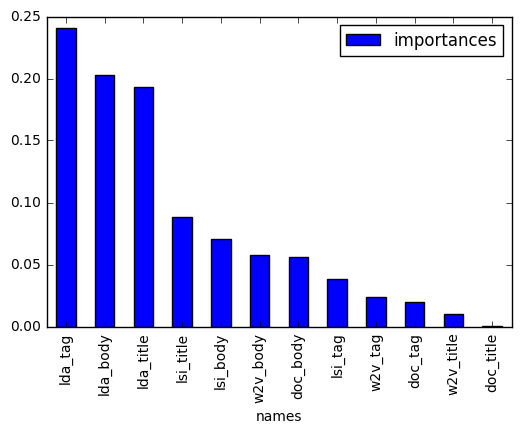

In [117]:
# build tree to see important feats?
feat_importance = clf.feature_importances_

feat_df = pd.DataFrame({
    'importances': feat_importance,
    'names': [u'doc_body', u'lda_body', u'lsi_body', u'w2v_body', u'doc_title',
       u'lda_title', u'lsi_title', u'w2v_title', u'doc_tag', u'lda_tag',
       u'lsi_tag', u'w2v_tag']
                        })
feat_df = feat_df.sort(['importances'], ascending=False)
feat_df.plot.bar(x="names", y="importances")